In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from fbprophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
os.chdir('drive')

We are out to find areas of the country that make the best candidates for property investment. Our base data set is median home value for every zip code in the country since 1996. In addition to our base data set, I am importing employment data from this source:

https://www.bls.gov/cew/downloadable-data-files.htm

This data source breaks down employment data by county. For each county in the country we have their total wages earned, their total establishments of employment, and the total number of jobs occupied in that county. These statistics tell us a lot about property value. We want to find economies that are growing and becoming more desirable places to be. Not only that, we want to find places that project to keep growing over the next few years so we can add to our investment in the shorter term. Let's import our two data files first:

In [0]:
housing = pd.read_csv('My Drive/Colab Notebooks/data/housing.csv', encoding='latin-1')
employment = pd.read_csv('My Drive/Colab Notebooks/data/master_employment_data.csv')

First step is to plot these four Arkansas Metro areas:

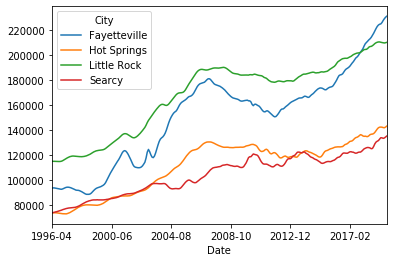

In [0]:
ark = housing[housing['State']=='AR']
metros = ['Hot Springs', 'Little Rock', 'Fayetteville','Searcy']
metrosdf = ark.loc[ark['City'].isin(metros)]
metrosdf = metrosdf.drop(columns=['RegionID','RegionName', 'State', 'Metro', 'CountyName','SizeRank'])
metros_group = metrosdf.groupby(by='City', as_index=False).mean()

meltmetros = metros_group.melt(id_vars=['City'], var_name='Date',value_name='Value')
meltmetros = meltmetros[['Date','City','Value']]

meltmetros.pivot(index="Date", columns="City", values="Value").plot()
plt.show()

Now we will move on to finding the zipcodes we want to invest in. I approached this problem in two different ways. 

1. Leveraged a Virtual Machine to run each zip code in the housing data through a Prophet forecast and then saw which zip codes had the highest positive percentage changes from now to three years from now.

2. Used the employment data set to find which general areas have been experiencing the most economic growth in terms of wages and jobs available, and then explore the best zip codes from those regions.

In [0]:
houseval = housing.drop(columns=['RegionID', 'State', 'City', 'Metro', 'CountyName','SizeRank'])
housemelt = houseval.melt(id_vars=['RegionName'], var_name='Date',value_name='Value')

def houseValForecast(zipcode):
    try:
        df = housemelt[housemelt['RegionName']==zipcode]
        if len(df) > 120:
            df.columns=['Region','Date','Val']
            
            valdf = df[['Date','Val']]
            valdf.columns=['ds','y']
            
            my_model = Prophet(interval_width=.95)
            my_model.fit(valdf)
            future_dates = my_model.make_future_dataframe(periods=36, freq='MS')
        
            forecast = my_model.predict(future_dates)
            forecast = forecast[['ds','yhat','yhat_lower','yhat_upper']]
            
            my_model.plot(forecast, uncertainty=True)
            plt.title('Forecast for zipcode %s' %str(zipcode))
            return()
            #return(my_model,forecast)
        else:
            print('not enough data for ' + str(zipcode))
            return(0)
    except:
        print('skipped ' + str(zipcode))

Here is the code that sends every zip code through the forecast, I used several other loops to complete this, all very similar to this one - so I won't actually show them moving forward:

```python
predictionsdict={}
allzips = list(data['RegionName'].unique())
i=0
for zipcode in allzips:
    print(str(len(allzips)-i) + ' zipcodes left...')
    forecastdf = houseValForecast(zipcode)
    if isinstance(forecastdf, int):
        i=i+1
        pass
    else:
        myindex = forecastdf.shape[0]
        prediction = forecastdf.iloc[myindex-1,1]
        prediction = round(prediction,0)
        percentage_change = prediction / forecastdf.iloc[myindex-4,1]
        predictionsdict.update({zipcode: percentage_change})
        i = i + 1
        
predictdf = pd.DataFrame()
predictdf = predictdf.append(predictionsdict, ignore_index=True)
predictdf = predictdf.T
predictdf.columns=['Predicted Change']
predictdf = predictdf.sort_values(by='Predicted Change', ascending=False)
predictdf.to_csv('AllZipsPredictions.csv')     
```

In [0]:
# Results:
topzipcodes_1 = pd.read_csv('My Drive/Colab Notebooks/data/AllZipsPredictions.csv')
topzipcodes_1.head(10)

# Our top 3 are:
# 1. Empire, Michigan
# 2. Kansas City, Missouri
# 3. Oxford County, Maine

,zip,Predicted Change
0,49630,1.087742
1,64109,1.055307
2,4217,1.049035
3,46601,1.043441
4,49636,1.042088
5,68057,1.040866
6,68933,1.040367
7,88030,1.037684
8,79745,1.037013
9,24529,1.036487


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


()

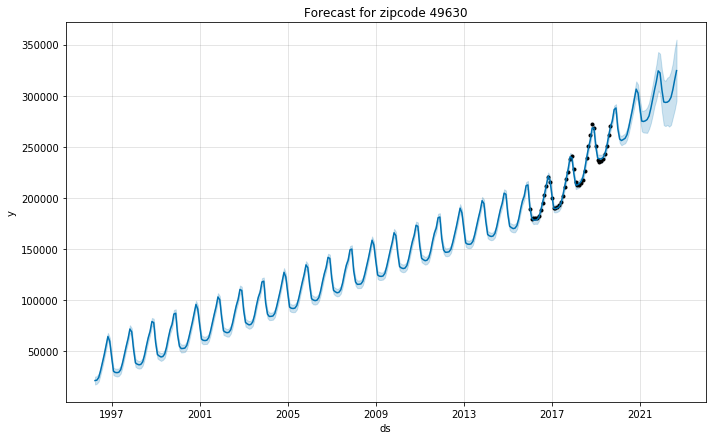

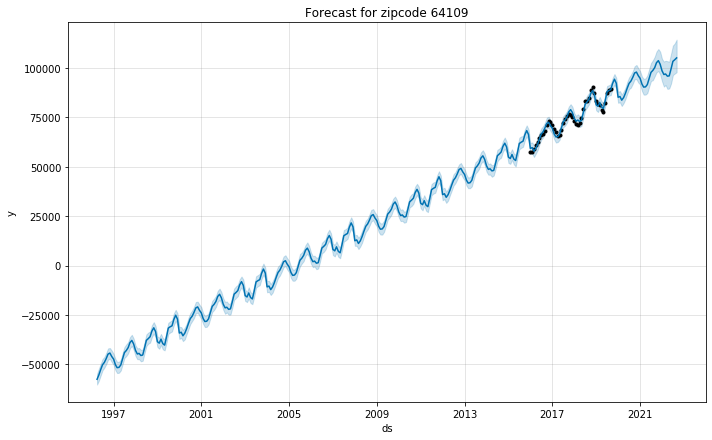

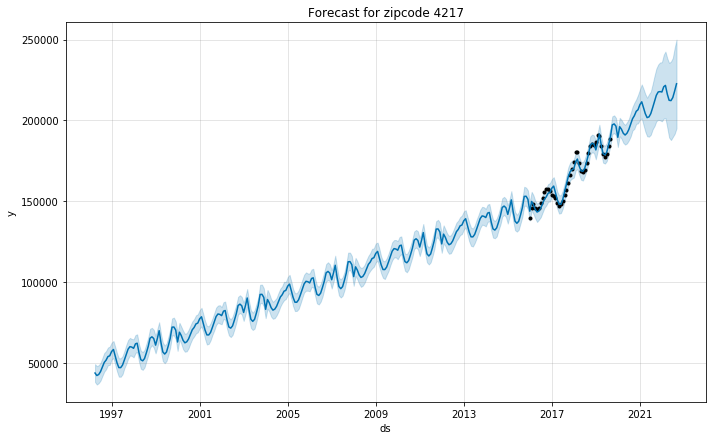

In [0]:
houseValForecast(49630)
houseValForecast(64109)
houseValForecast(4217)

Making our recommendations this way puts a lot of trust in the model, and I do not have that much trust in it. I went through the employment data and ran every county through a Prophet forecast to show which areas of the country are wages and jobs really booming. These are two things you want to see when you're trying to prognosticate at future property values. If the local economy is growing and more wealth is being created in an area, that drives up the value of everything around - which is where we want to be!

Let's get into our employment data set. We have a bit of cleaning to do here. First we have full state names written out in the employment data set, while we have abbreviations in the housing data set. We will bring in another data source (I made this one myself) that we will use to map the state names to their abbreviations in the employment data. Additionally, we will also clean up the numbers so we don't have commas, and we will change a few column names for continuity purposes.

Both data sets have the county name listed, so those columns can be used to compare the data together. In the employment data we need to replace "St." with "Saint" to match the housing data. We will then segment the data into three different data sets each with the information we are after. Let's do all of this in the next block:

In [0]:
employment = employment.loc[:, ~employment.columns.str.contains('^Unnamed')]
stateabbrevdf = pd.read_csv('My Drive/Colab Notebooks/data/stateabbrevs.csv')
stateabbrevsdict = dict(zip(stateabbrevdf.State, stateabbrevdf.Abbrev))
employment = employment.rename(columns={'Area': 'CountyName'})
employment['State'] = employment['St Name'].map(stateabbrevsdict)
employment['Annual Average Establishment Count'] = employment['Annual Average Establishment Count'].str.replace(',','')
employment['Annual Average Employment'] = employment['Annual Average Employment'].str.replace(',','')
employment['Annual Total Wages'] = employment['Annual Total Wages'].str.replace(',','')
employment['Annual Average Pay'] = employment['Annual Average Pay'].str.replace(',','')
employment['Annual Average Establishment Count'] = pd.to_numeric(employment['Annual Average Establishment Count'])
employment['Annual Average Employment'] = pd.to_numeric(employment['Annual Average Employment'])
employment['Annual Total Wages'] = pd.to_numeric(employment['Annual Total Wages'])
employment['Annual Average Pay'] = pd.to_numeric(employment['Annual Average Pay'])
employment['CountyName'] = employment['CountyName'].str.split(',').str[0]
employment['CountyName'] = employment['CountyName'].str.replace('St.','Saint')

totwages = employment[employment['Ownership'] == 'Total Covered']
totwages = totwages[['Year','CountyName','State','Annual Total Wages']]
totwages["CountyState"] = totwages["CountyName"] + ', ' + totwages["State"]

establishments = employment[employment['Ownership'] == 'Total Covered']
establishments = establishments[['Year','CountyName','State','Annual Average Establishment Count']]
establishments["CountyState"] = establishments["CountyName"] + ', ' + establishments["State"]

jobs = employment[employment['Ownership']=='Total Covered']
jobs = jobs[['Year', 'CountyName', 'State', 'Annual Average Employment']]
jobs["CountyState"] = jobs["CountyName"] + ', ' + jobs["State"]

# Quick peak at one of the new datasets
totwages.head(5)

,Year,CountyName,State,Annual Total Wages,CountyState
0,1999,Autauga County,AL,255909770,"Autauga County, AL"
5,1999,Baldwin County,AL,1042531260,"Baldwin County, AL"
10,1999,Barbour County,AL,271692156,"Barbour County, AL"
15,1999,Bibb County,AL,82181620,"Bibb County, AL"
20,1999,Blount County,AL,202414293,"Blount County, AL"


I ran all counties through three different functions to predict their changes in wages, job establishments, and jobs taken. Each loop took about three hours, here are the results:

In [0]:
wages = pd.read_csv('My Drive/Colab Notebooks/data/Predicted Wages Change.csv')
wages = wages.sort_values(by='Predicted Change', ascending=False)
wages.columns=['County','Predicted Change']
wages = wages[~wages['County'].str.match('Unknown')]

establishments = pd.read_csv('My Drive/Colab Notebooks/data/Predicted Establishments Change.csv')
establishments = establishments.sort_values(by='Predicted Change', ascending=False)
establishments.columns=['County','Predicted Change']
establishments = establishments[~establishments['County'].str.match('Unknown')]

jobs = pd.read_csv('My Drive/Colab Notebooks/data/Predicted Jobs Change.csv')
jobs = jobs.sort_values(by='Predicted Change', ascending=False)
jobs.columns=['County','Predicted Change']
jobs = jobs[~jobs['County'].str.match('Unknown')]

I am interested to see if there are states that really pop out amongst these leaderboards. I will make a state column in the data frames by splitting the County column off after the comma, take the top 50 values, and then visualize the frequencies.

Text(0.5, 0.98, 'States in the Top 50 Wage Increasers')

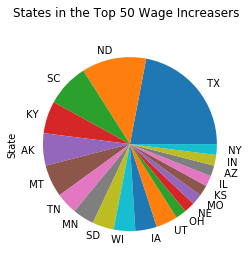

In [0]:
wages['State'] = wages['County'].str.split(',').str[1]
wages_leaders = wages.head(50)
jobs['State'] = jobs['County'].str.split(',').str[1]
jobs_leaders = jobs.head(50)
establishments['State'] = establishments['County'].str.split(',').str[1]
estab_leaders = establishments.head(50)

x = wages_leaders['State'].value_counts(normalize=True)
x.plot.pie(figsize=(4,4))
plt.suptitle("States in the Top 50 Wage Increasers")

Text(0.5, 0.98, 'States in the Top 50 Jobs Held Increasers')

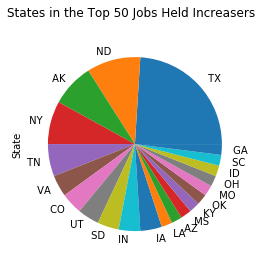

In [0]:
x = jobs_leaders['State'].value_counts(normalize=True)
x.plot.pie(figsize=(4,4))
plt.suptitle("States in the Top 50 Jobs Held Increasers")

Text(0.5, 0.98, 'States in the Top 50 Jobs Held Increasers')

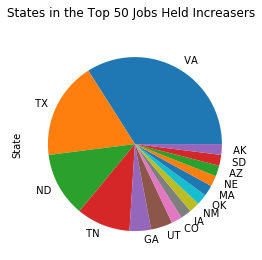

In [0]:
x = estab_leaders['State'].value_counts(normalize=True)
x.plot.pie(figsize=(4,4))
plt.suptitle("States in the Top 50 Jobs Held Increasers")

Texas, North Dakota, and Alaska really stand out here - with Texas being the overall leader by a good margin. I went through and ran a prophet forecast for the zip codes in Texas that stood out in the employment data to see which were the highest predicted home value increasers. I looked at these counties:

Kendall County, TX
Comal County, TX
Rockwall County, TX
Guadalupe County, TX

Here are the results:

In [0]:
texas_counties = pd.read_csv('My Drive/Colab Notebooks/data/TexasZipCodesHomeValPredictions.csv')
texas_counties

,Zip,Predicted Change
0,78133,1.014515
1,78623,1.014182
2,75189,1.013341
3,78130,1.013120
4,78108,1.012272
5,78123,1.011849
6,75032,1.011590
7,78132,1.011558
8,78154,1.011444
9,78006,1.010948


Those top four are all very close, so let's run them through the home value forecast:

()

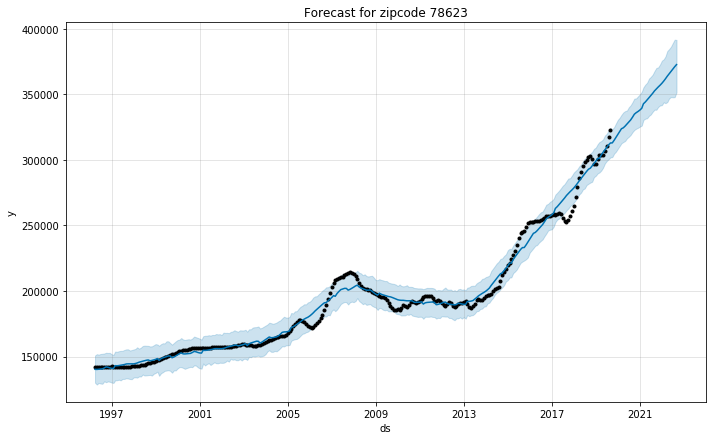

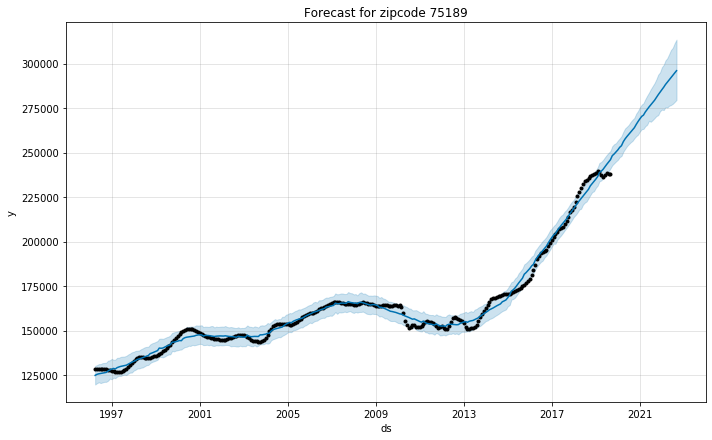

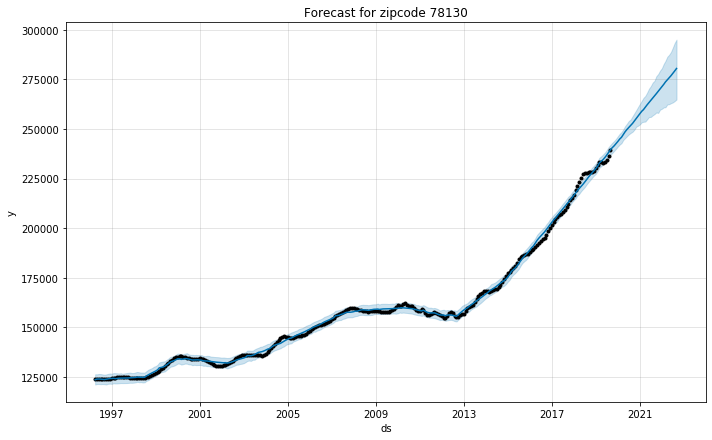

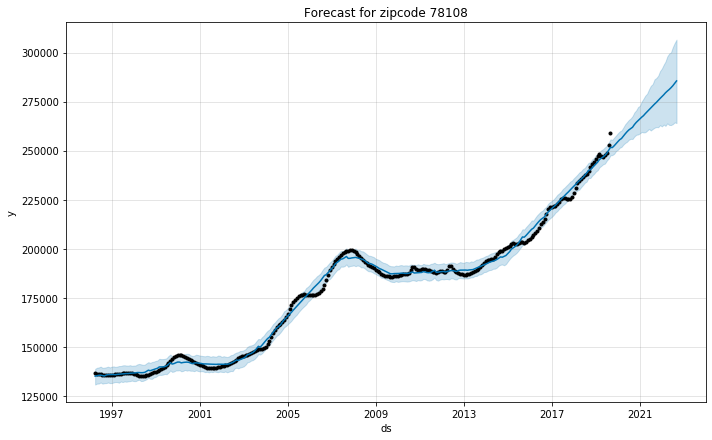

In [0]:
houseValForecast(78623)
houseValForecast(75189)
houseValForecast(78130)
houseValForecast(78108)

We see that 75189 (in Royse City, TX) is currently has the lowest median home values, and there was a short sign of stagnation at the very end of our real data there, so that is the least attractive of these options. I don't want to put all my eggs in one texas-sized basket here either, so I think I am going to pair my favorite two Texas zipcodes here with Empire, Michigan. 

*Conclusion*

Q1: What three zip codes do I choose to invest in?
My three selections from zip codes to invest in are *49630 (Empire, Michigan)*, *78130 (New Braunfels, TX)*, and *78623 (Canyon Lake, TX)*.

Empire, Michigan is a beautiful place, from what I can see, right on Lake Michigan. It's a very small town with just 375 residents per the 2010 census. There is a nice 1.03 acre plot of land for sale right now for $57,000 - so I'll offer like $37,000 and settle for $45,000 - duh! Then I'll sit there in a chair and look at the Lake while I get rich.

Canyon Lake, Texas is a much bigger place, just outside of San Antonio. It looks like they have had some issues in the past with flooding when the Canyon Dam has busted open - so we'll go ahead and pile up the floor insurance on that property!

New Braunfels, Texas is real close to Canyon Lake, Texas. It is shaped really weird... thanks a lot gerrymandering! 

I am investing pretty heavily into Texas, and I am guessing that my property value in Canyon Lake will be correlated with the value in New Braunfels. Texas did recently almost elect Beto O'Rourke over Ted Cruz, which is a little alarming for a potential property investor, so we will keep our eye on the changing political landscape in Texas and bail out if we think too much government economic intervention is coming. I bet I'm the first student to make this assignment political.

Q2: Did I or how did I downsample?
Well, I did and I didn't! I chose to make a decision based on what I think are positive economic signals about the future. If a place is gaining lots of jobs and seeing wages increase, that can only mean good things for the property values in that area. I chose to go at it this assignment by finding the areas where the economy is really booming and investing in there before the boom ends. This makes me feel a little better about my investment rather than just relying solely on the Prophet forecast for every zip code.